Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

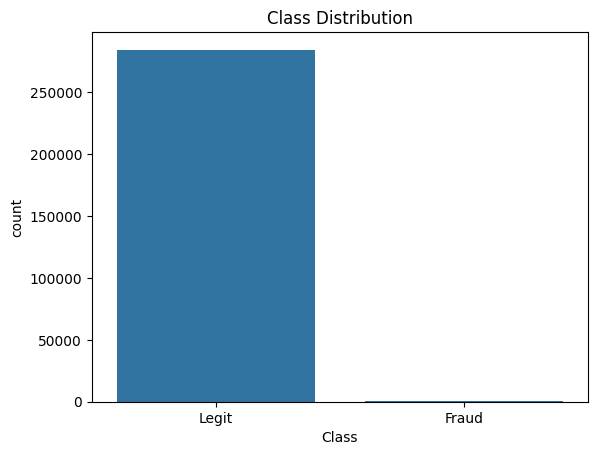

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


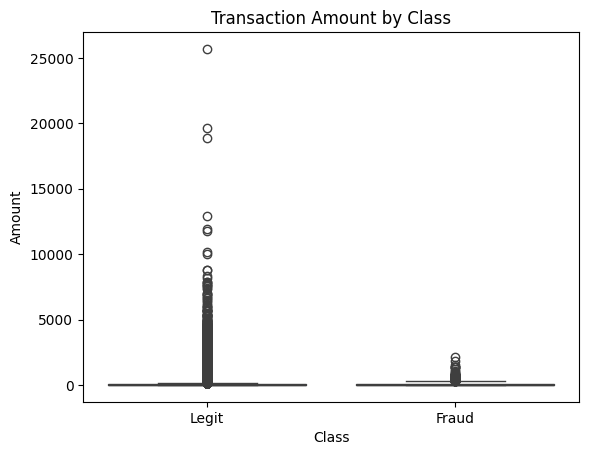

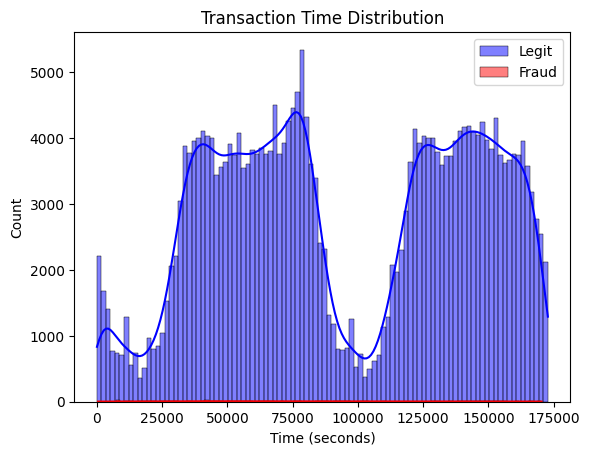

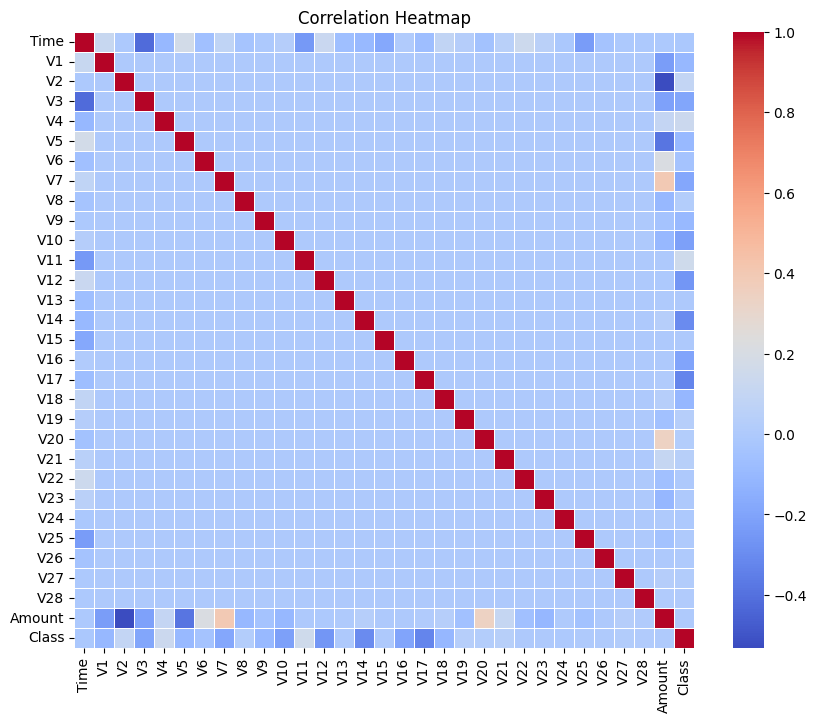

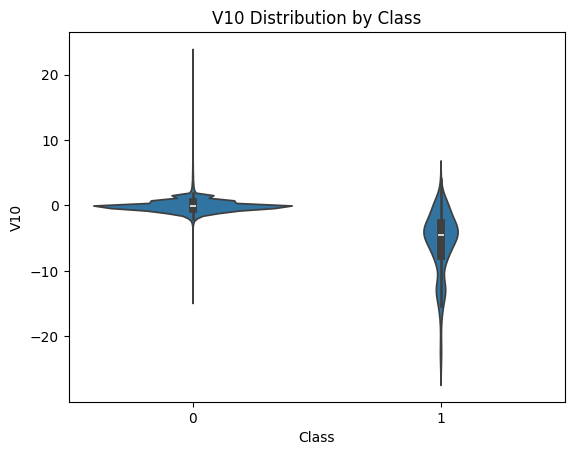

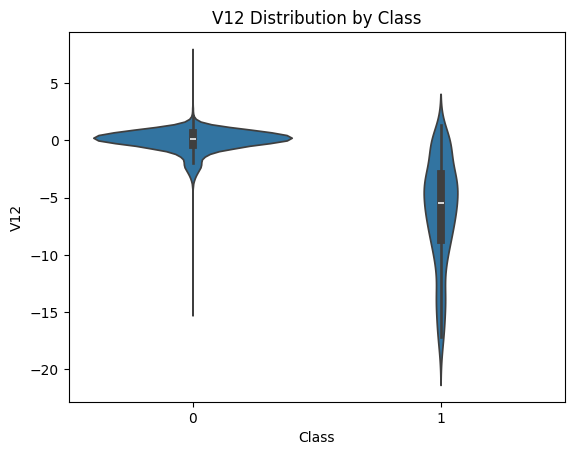

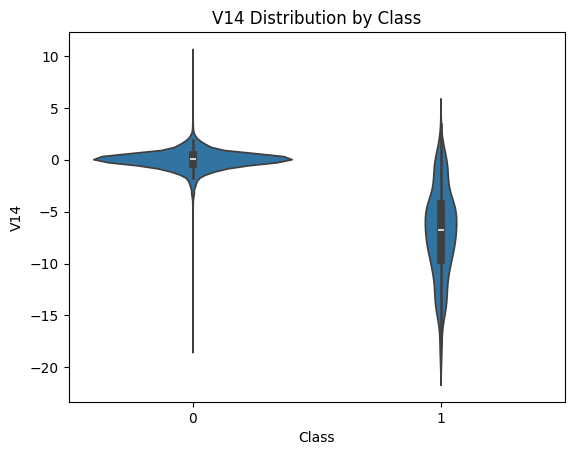

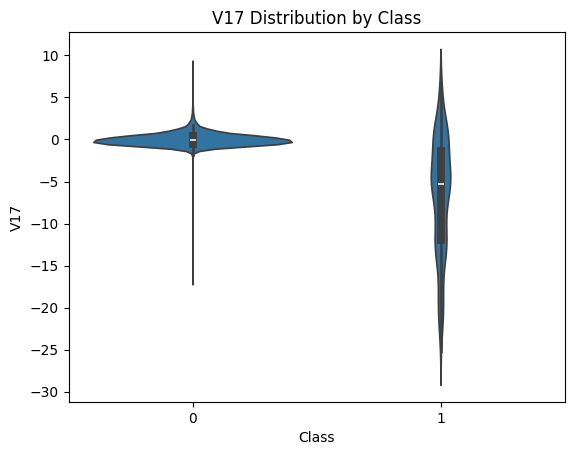

Balanced class counts:
Class
0    492
1    492
Name: count, dtype: int64
Training samples: 787, Testing samples: 197
                 Model  Precision    Recall  F1 Score       AUC
0        Random Forest   0.956044  0.887755  0.920635  0.973511
1  Logistic Regression   0.966667  0.887755  0.925532  0.968254


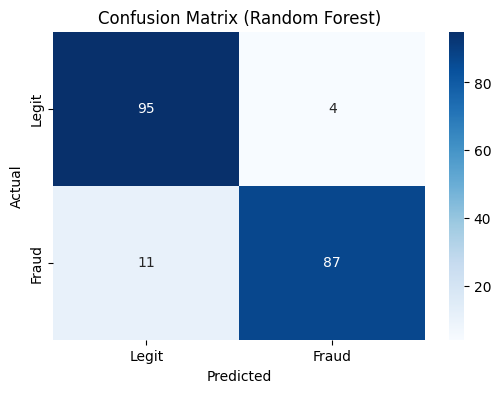

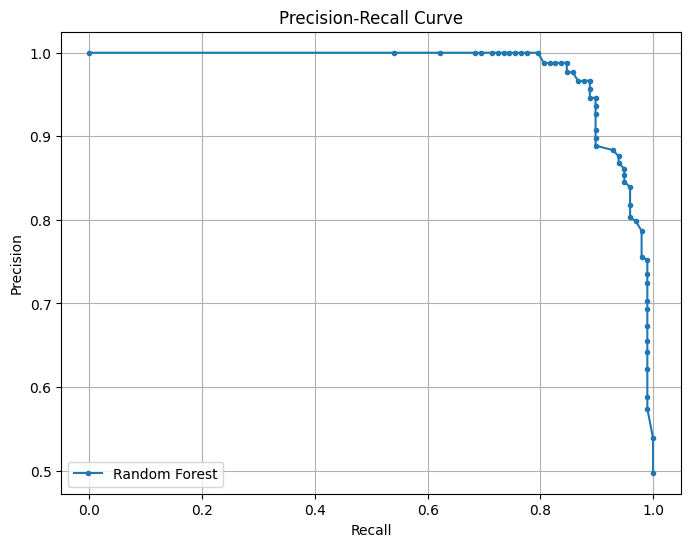

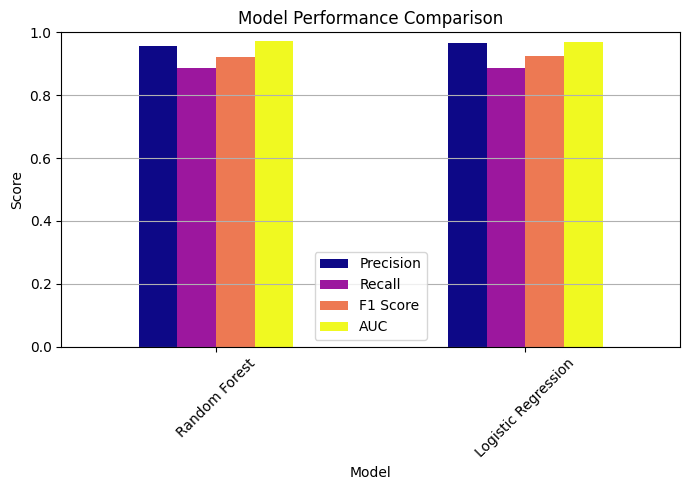

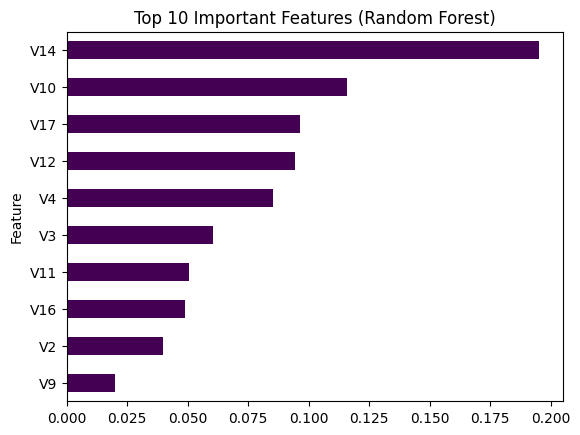

<Figure size 640x480 with 0 Axes>

In [2]:
# =======================================
# Credit Card Fraud Detection ML Project
# =======================================

!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, precision_recall_curve, confusion_matrix)
from sklearn.metrics import precision_score, recall_score, f1_score



file_id = "10MUMS5WSmolTcc8hl0Gh8wrhwl2LykWN"
url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(url)

print("Dataset info:")
print(df.info())
print(df.head())

sns.countplot(data=df, x='Class')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Legit', 'Fraud'])
plt.show()
print(df['Class'].value_counts(normalize=True))

sns.boxplot(data=df, x='Class', y='Amount')
plt.title("Transaction Amount by Class")
plt.xticks([0, 1], ['Legit', 'Fraud'])
plt.show()

sns.histplot(df[df['Class'] == 0]['Time'], bins=100, color='blue', label='Legit', kde=True)
sns.histplot(df[df['Class'] == 1]['Time'], bins=100, color='red', label='Fraud', kde=True)
plt.title('Transaction Time Distribution')
plt.xlabel('Time (seconds)')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

features_to_plot = ['V10', 'V12', 'V14', 'V17']
for feature in features_to_plot:
    sns.violinplot(x='Class', y=feature, data=df)
    plt.title(f'{feature} Distribution by Class')
    plt.show()

df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
print("Balanced class counts:")
print(df_balanced['Class'].value_counts())

X = df_balanced.drop(columns=['Class'])
y = df_balanced['Class']

scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_scores_rf = rf_model.predict_proba(X_test)[:, 1]

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_scores_log = log_model.predict_proba(X_test)[:, 1]

def get_metrics(y_true, y_pred, y_scores, model_name):
    return {
        "Model": model_name,
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_scores)
    }

results = []
results.append(get_metrics(y_test, y_pred_rf, y_scores_rf, "Random Forest"))
results.append(get_metrics(y_test, y_pred_log, y_scores_log, "Logistic Regression"))

df_results = pd.DataFrame(results)
print(df_results)

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores_rf)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

df_plot = df_results.set_index("Model")
df_plot.plot(kind='bar', figsize=(7,5), colormap='plasma')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

importances = rf_model.feature_importances_
features = X_train.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

feature_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False, colormap='viridis')
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

df_results.to_csv("model_comparison_results.csv", index=False)
plt.savefig("model_comparison_plot.png", dpi=300)
